# retinal image model
## initilialising python environment
We first start of by importing tensorflow and os (to access files and matplotlib), I am running this on my personal device so in order to speed up running going to try and multithread it

In [ ]:
import os
import tensorflow as tf
from tensorflow.config.threading import set_intra_op_parallelism_threads, set_inter_op_parallelism_threads
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import random
num_cpu_cores = os.cpu_count()
print("Number of CPU cores:", num_cpu_cores)
set_intra_op_parallelism_threads(num_cpu_cores)
set_inter_op_parallelism_threads(num_cpu_cores)


Here i set my path and use the os function to create paths to the folders containing the eyes images, i also included a print statement to see how many images are in each folder

In [ ]:
path = '/Users/yoofilarbi/Documents/AI_coursework/eye-images/'
Normal = os.path.join(path,'1_normal/')
Cataracts = os.path.join(path,'2_cataract/')
Glaucoma = os.path.join(path,'2_glaucoma/')
print("Number of uninfected cells", len(os.listdir(Normal)))
print("Number of Cataracts cells", len(os.listdir(Cataracts)))
print("Number of glaucoma cells", len(os.listdir(Glaucoma)))

## defining loading in function
pretty much just assigns the number of classes to  the number of sub directories. then reads the image in RGB then appends the image with the label corresponding to which subdirectory it was in. 

This is done until its gone thruogh all the items in the directory. I decided to load in image in 300x200 because changing it to 100x100 or 214x214 stretched the image and i wasn't sure if that would affect the performance of my model alot

In [4]:
import cv2  # used to read images
import numpy as np

def load_images(directories, n_images=900000):
    """
    Reads in images and assigns class labels
    Parameters:
        directories: A list of the sub-directories
        n_images:    The maximum number of images to load from each directory
    Returns:
        images (numpy.ndarray) : Image data
        label (numpy.ndarray      : Labels of each image
    """
    images = []
    labels = []
    for label, sub_dir in enumerate(directories):
        num=1
        for file_name in os.listdir(sub_dir):
            if num > n_images:
                break
            img_path = os.path.join(sub_dir, file_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (300, 200)) 
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(label)
                num+=1
    return np.array(images), np.array(labels)

## defining augmention
for my augmentation i used PIL,

1. max samples = max(class counts) + num of augmentations , we need to set max samples now because the class count will increase as function runs
2. num to augment= max samples - class count , this means that as class count increases num to augment drops
3. it selects a random image
4. it then augments that image by randomly choosing within a range of changes
5. for Glaucoma and Normal CLAHE applied (have to switch colour format)
6. stores it in augmented images
7. at the end adds all the newly augmented images to main sets
8. then randomly shuffles by choosing a random permutation and applyin the **same** permutation to both image and label sets

In [20]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from PIL import Image, ImageEnhance
import random


def augment_data(images, labels, num_augmentations_per_class,augmentation_strategy = 'glaucoma'):
    unique_labels, class_counts = np.unique(labels, return_counts=True)
    max_samples = np.max(class_counts) + num_augmentations_per_class

    augmented_images = []
    augmented_labels = []

    for label, class_count in zip(unique_labels, class_counts):
        class_indices = np.where(labels == label)[0]
        class_images = images[class_indices]

        num_to_augment = max_samples - class_count

        for i in range(num_to_augment):
            index = np.random.choice(len(class_images))
            image = class_images[index]

            # Apply custom augmentations
            angle = random.randint(-20, 20)  # Rotate by ±15 degrees
            image = Image.fromarray(image)  # Convert to PIL Image
            image = image.rotate(angle)

            if random.choice([True, False]):
                image = image.transpose(Image.FLIP_LEFT_RIGHT)

            enhancer = ImageEnhance.Brightness(image)
            brightness_factor = random.uniform(0.98, 1.05)
            image = enhancer.enhance(brightness_factor)

            contrast_enhancer = ImageEnhance.Contrast(image)
            contrast_factor = random.uniform(0.95, 1.1)
            image = contrast_enhancer.enhance(contrast_factor)

            if augmentation_strategy == 'glaucoma' and  (label == 0 or label == 2):
                # Convert to NumPy array (0-255 uint8)
                img_np = np.array(image)
                # Convert from RGB to LAB color space
                lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
                l, a, b = cv2.split(lab)
                clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
                l_clahe = clahe.apply(l)
                lab = cv2.merge((l_clahe, a, b))
                # Convert back to RGB
                img_np = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
                image = Image.fromarray(img_np)

            width, height = image.size #zoom function
            zoom_factor = random.uniform(0.95, 1.05)
            left = int((1 - zoom_factor) * width / 2)
            top = int((1 - zoom_factor) * height / 2) #generates size to crop image by zoom factor
            right = int(width - left) #make sure cropping is done equally on both sides
            bottom = int(height - top)
            image = image.crop((left, top, right, bottom)) #crops by generated sizes
            image = image.resize((width, height))

            augmented_images.append(np.array(image))  # Convert back to NumPy array
            augmented_labels.append(label)

    # Convert lists to NumPy arrays
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    # Concatenate the original and augmented data
    all_images = np.concatenate((images, augmented_images))
    all_labels = np.concatenate((labels, augmented_labels))

    # Shuffle the data
    permuted_indices = np.random.permutation(len(all_labels))
    all_images = all_images[permuted_indices]
    all_labels = all_labels[permuted_indices]

    return all_images, all_labels

Loading in the images as X and Y

In [22]:
X, y = load_images([Normal,Cataracts,Glaucoma])


## visualising images and augmentations
Here i import all the modules i need for training and splitting data as well as building my model and some of the metrics
I also split the data but this is a test run just to check and visualise the augmentations and the class sizes after augmentations

i di this by creating a matplot image by just choosing the first 3 images in my set and plotting them in a mat plot lib

Class distribution after augmentation:
Normal: 539
Cataract: 539
Glaucoma: 539


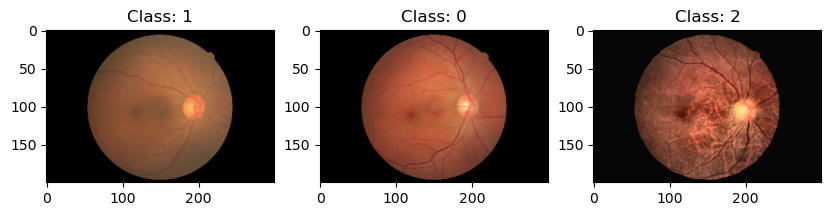

In [36]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201,DenseNet121,ResNet152V2,EfficientNetB5
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,Rescaling
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100,stratify=y)

X_aug, y_aug = augment_data(X_train, y_train, 300)
print("Class distribution after augmentation:")
print(f"Normal: {sum(y_aug == 0)}")
print(f"Cataract: {sum(y_aug == 1)}")
print(f"Glaucoma: {sum(y_aug == 2)}")

# Visualize augmented samples
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(X_aug[i].astype(np.uint8))
    plt.title(f"Class: {y_aug[i]}")
plt.show()

## defining the model

Here i define my model, i do this first by making the Squeeze and excitation block, the code i was able to figure out from google, it works by 
1. extracting the number of filters from the input.
2. It then performs recalibration on these filters.
3. It then takes every filter and turns it into a single vector (squeeze),
4. there it is reshaped and fed into dense layers
5. reduces channels by ratio and uses relu for activation, forces block to find key filters
6. it then uses next dense layers to apply weight from sigmoid activation to each filter, in essence enhancing or emphasising certain parts of the model

I then form my densenet201 and make the last 14 layers trainable (got me highest test results in preliminary)
i also include dropout to avoid oveerfitting

In [127]:


# Define input shape (height, width, channels)
INPUT_SHAPE = (200, 300, 3)  




def se_block(input_tensor, ratio=16):
    """Squeeze-and-Excitation block for channel-wise feature recalibration."""
    channel_axis = -1
    filters = int(input_tensor.shape[channel_axis])
    se_shape = (1, 1, filters)
    
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)
    se = layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = layers.multiply([input_tensor, se])
    return x

# Load DenseNet201 as the base model
base_model = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)

base_model.trainable = False  # 
for layer in base_model.layers[-14:]:  # Freeze all layers except the last 14
    layer.trainable = True

# Build the full model 
def build_full_model():
    inputs = tf.keras.Input(shape=INPUT_SHAPE)
    x = base_model(inputs, training=False)
    x = se_block(x, ratio=16)  # Add SE block here to strengthen feature propagation
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(3, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model






## Cross validation
I use stratified K fold to preserve class imbalance in my validation sets
I create a bunch of lists, this is to store the results of each fold for later visualisation

So i use SKF to split X and y (unaugmented data) then in make my training and validation data from those splits
then i augment only my training data and build and compile model
after very fold it prints out the results for that validation set

after i training i evaluate my model against my unaugmented untouched validation set
then i calculate the metrics and the probabilities and store those 
I also create a confusion matrix for each fold (this is late averaged)

This is done for every fold

In [2]:

from sklearn.metrics import classification_report
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
fold_histories = [] #training and validation losses during training set
fold_accuracies = [] #accuracy for final validation evaluation
fold_losses = [] #loss for final validation evaluation 
fold_confusion_matrices = [] # confusion matrix results
all_val_true = [] # labels of validation prediction to make visualisation
all_val_pred_probs = [] # probabilities of validation prediction 
all_metrics=[] # store of all the metric in each classification report

fold_no = 1
for train_idx, val_idx in skf.split(X, y):
    print(f"\n--- Fold {fold_no} ---")
    X_train_cv, X_val_cv = X[train_idx], X[val_idx]
    y_train_cv, y_val_cv = y[train_idx], y[val_idx]


    X_aug, y_aug = augment_data(X_train_cv, y_train_cv, 300)
    # Build model for this fold
    model_cv = build_full_model()
    model_cv.compile(
    optimizer=optimizers.Adamax(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
    

    # Train the model on this fold
    history = model_cv.fit(
        X_aug,
        tf.keras.utils.to_categorical(y_aug, 3),
        validation_split=0.2,
        epochs=25,
        batch_size=32,
        callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
        shuffle=True,
        verbose=1,
    )
    fold_histories.append(history.history)
    
    # Evaluate on the validation fold
    scores = model_cv.evaluate(X_val_cv, tf.keras.utils.to_categorical(y_val_cv, 3), verbose=0)
    fold_losses.append(scores[0])
    fold_accuracies.append(scores[1])
    print(f"Fold {fold_no} - Loss: {scores[0]:.3f}, Accuracy: {scores[1]:.3f}")
    
    # Accumulate predictions and true labels for additional metrics later
    val_pred_probs = model_cv.predict(X_val_cv)
    all_val_pred_probs.append(val_pred_probs)
    all_val_true.append(tf.keras.utils.to_categorical(y_val_cv, 3))
    
    # Compute confusion matrix for this fold
    y_val_pred = np.argmax(val_pred_probs, axis=1)
    cm = confusion_matrix(y_val_cv, y_val_pred, labels=[0,1,2])
    fold_confusion_matrices.append(cm)


    report = classification_report(y_val_cv, y_val_pred, target_names=['Normal', 'Cataracts', 'Glaucoma'], output_dict=True)
    all_metrics.append(report)

    
    fold_no += 1
;

NameError: name 'StratifiedKFold' is not defined

## Metric report
i stored all my metrics in a list of classification reports, this classifcation report gives you the metrics
i enumerate it the list to get the fold number, and for each classification report i turn it into a dataframe then i choose the useful columns then i append a column for the fold number

i then concatenate these dataframes all together to make a large dataframe of the metrics from every single one
i also create an average table by grouping by index (each class) and averaging everything out
i also saved it as a csv

In [131]:
import pandas as pd
fold_tables = []
for fold_idx, metrics_dict in enumerate(all_metrics, start=1):
    # Convert dictionary to DataFrame and transpose it so that each row corresponds to a class
    df_fold = pd.DataFrame(metrics_dict).transpose()
    # Keep only the rows for the three classes
    df_fold = df_fold.loc[['Normal', 'Cataracts', 'Glaucoma']]
    # Add a column to indicate the fold number
    df_fold['Fold'] = fold_idx
    fold_tables.append(df_fold)

# Concatenate the per-fold DataFrames into one combined DataFrame
combined_metrics = pd.concat(fold_tables)
# Reorder columns for clarity
combined_metrics = combined_metrics[['Fold', 'precision', 'recall', 'f1-score', 'support']]

print("Classification Metrics per Fold:")
print(combined_metrics)

# Compute average metrics per class across folds (averaging over all folds)
avg_metrics = combined_metrics.groupby(combined_metrics.index).mean()
print("\nAverage Metrics Across All Folds:")
print(avg_metrics)

#save the table to a CSV file for further analysis
combined_metrics.to_csv("cv_classification_metrics.csv", index=True)


Classification Metrics per Fold:
           Fold  precision    recall  f1-score  support
Normal        1   0.753425  0.916667  0.827068     60.0
Cataracts     1   0.800000  0.800000  0.800000     20.0
Glaucoma      1   0.500000  0.190476  0.275862     21.0
Normal        2   0.833333  0.916667  0.873016     60.0
Cataracts     2   0.888889  0.800000  0.842105     20.0
Glaucoma      2   0.750000  0.600000  0.666667     20.0
Normal        3   0.888889  0.933333  0.910569     60.0
Cataracts     3   0.909091  1.000000  0.952381     20.0
Glaucoma      3   0.866667  0.650000  0.742857     20.0
Normal        4   0.904762  0.950000  0.926829     60.0
Cataracts     4   0.900000  0.900000  0.900000     20.0
Glaucoma      4   0.941176  0.800000  0.864865     20.0
Normal        5   0.909091  1.000000  0.952381     60.0
Cataracts     5   1.000000  0.850000  0.918919     20.0
Glaucoma      5   1.000000  0.850000  0.918919     20.0

Average Metrics Across All Folds:
           Fold  precision    recall

## Confusion matrix
well first i store the all val true(validation labels) and all val prob (validation probs)
i then calculate average loss , and accuracy and also the max 

i then concatenate all the probabilities and the lables as well as calculating my precision and recall score, for the whole model
i then take my confusion matrix and sum the results of  confusion matrix and divide it by the length (or the number of folds)
then i can 


--- Cross-Validation Results ---
Average Loss: 0.350, Max Loss: 0.591
Average Accuracy: 0.863, Max Accuracy: 0.940
Precision: 0.882, Recall: 0.884, F1 Score: 0.881
Average Confusion Matrix:
[[56.6  1.4  2. ]
 [ 2.4 17.4  0.2]
 [ 7.2  0.6 12.4]]


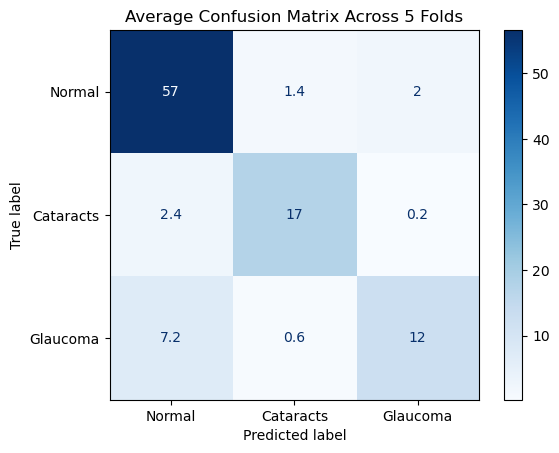

In [133]:
all_val_true=all_val_true_storage #storing important metrics
all_val_pred_probs=all_val_pred_probs_storage
avg_loss = np.mean(fold_losses) # some more metrics for the whole model , max vs average loss
max_loss = np.max(fold_losses) 
avg_acc = np.mean(fold_accuracies) #max vs average accuracies
max_acc = np.max(fold_accuracies)

all_val_true_concat = np.argmax(np.vstack(all_val_true), axis=1) #concatenate all the labels
all_val_pred_concat = np.argmax(np.vstack(all_val_pred_probs), axis=1) #concatenate all the probailites

precision = precision_score(all_val_true_concat, all_val_pred_concat, average='weighted') # find the weighted average across all 5 folds
recall = recall_score(all_val_true_concat, all_val_pred_concat, average='weighted')
f1 = f1_score(all_val_true_concat, all_val_pred_concat, average='weighted')

print("\n--- Cross-Validation Results ---") #printing out resulsts
print(f"Average Loss: {avg_loss:.3f}, Max Loss: {max_loss:.3f}")
print(f"Average Accuracy: {avg_acc:.3f}, Max Accuracy: {max_acc:.3f}")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}")

# Average Confusion Matrix
avg_cm = np.sum(fold_confusion_matrices, axis=0) / len(fold_confusion_matrices)
print("Average Confusion Matrix:")
print(avg_cm)
disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm, display_labels=["Normal", "Cataracts", "Glaucoma"])
disp.plot(cmap='Blues')
plt.title("Average Confusion Matrix Across 5 Folds")
plt.savefig('confusion.png') # save the figure
plt.show()


## training and validation graphs
i take the num of epochs which is the smallest number of epochs (rememeber i put in a early stopping so not all epochs have neccesarily the same length) then i collect the training and validation split histories for all 5 folds stored in fold_histories

In [156]:
num_epochs = min([len(h['accuracy']) for h in fold_histories])
epochs_range = range(1, num_epochs+1)

# Collect accuracy and loss arrays for each fold
train_acc = np.array([h['accuracy'][:num_epochs] for h in fold_histories])
val_acc = np.array([h['val_accuracy'][:num_epochs] for h in fold_histories])
train_loss = np.array([h['loss'][:num_epochs] for h in fold_histories])
val_loss = np.array([h['val_loss'][:num_epochs] for h in fold_histories])




### training and validation graphing using matplot lib
I make my plot and subplot for both accuracy and loss
then for accuracy, the first subplot, i plot for the range of the shape of the array i have (which is the folds).
so for each fold it plots the training accuracy for the epoch in blue and validation split accruacy in red at **lower** opacities

I then used the max argument to highlight the fold with max training data at a specifc epoch 
i also used fill between the min and max to see the range at very low opacity

i did similar for the loss but with minimums instead of maximums

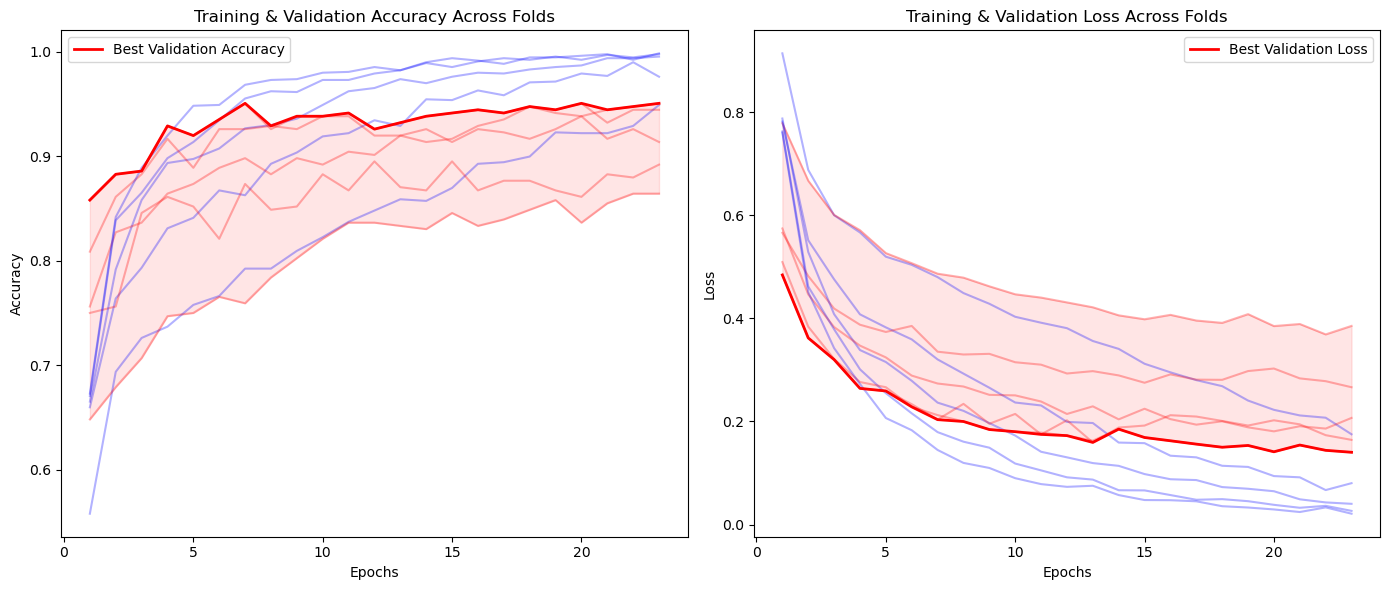

In [159]:
plt.figure(figsize=(14, 6))
# Accuracy plot: plot all fold curves with transparency, then plot the best curve
plt.subplot(1,2,1)
for i in range(train_acc.shape[0]):
    plt.plot(epochs_range, train_acc[i], color='blue', alpha=0.3)
    plt.plot(epochs_range, val_acc[i], color='red', alpha=0.3)
# For demonstration, highlight the maximum validation accuracy curve across folds per epoch
plt.plot(epochs_range, np.max(val_acc, axis=0), color='red', label='Best Validation Accuracy', linewidth=2)
plt.fill_between(epochs_range, np.min(val_acc, axis=0), np.max(val_acc, axis=0), color='red', alpha=0.1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Across Folds')
plt.legend()
plt.subplot(1,2,2)
for i in range(train_loss.shape[0]):
    plt.plot(epochs_range, train_loss[i], color='blue', alpha=0.3)
    plt.plot(epochs_range, val_loss[i], color='red', alpha=0.3)
plt.plot(epochs_range, np.min(val_loss, axis=0), color='red', label='Best Validation Loss', linewidth=2)
plt.fill_between(epochs_range, np.min(val_loss, axis=0), np.max(val_loss, axis=0), color='red', alpha=0.1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Across Folds')
plt.legend()
plt.tight_layout()
plt.savefig('cv_training_validation_curves2.png')
plt.show()


## Precision-recall and ROC curve
So first i generate my results and plot them for each class in the PR curve
i use precision recall curve package from sklearn, to generate it for that specific fold)
I then use average precision score (auc under the pr curve.

i generate my f1 score by taking the position of the max prediction (so the highest probaility and the correct label) since it is one hot encoded. so i get my true label and the predicted label and it uses this to generate the F1 score

I then plot the PR curve as a subplot
and i also plot the ROC curve as a subplot
then it is saved

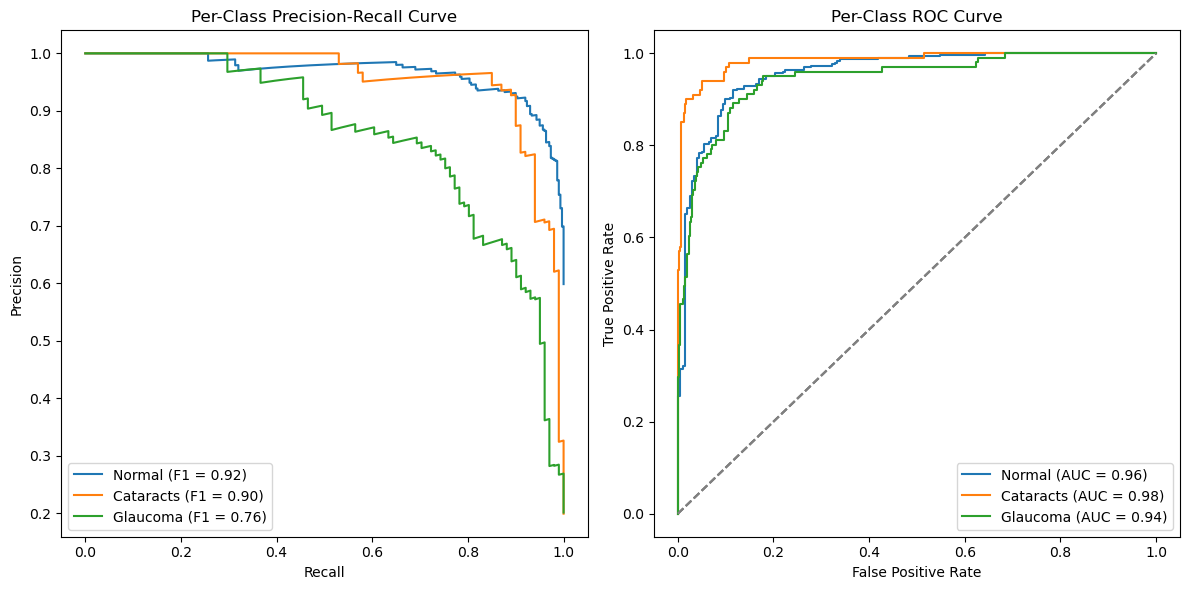

In [162]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score

# Assume all_val_true and all_val_pred_probs are of shape (total_samples, num_classes)
# Flatten all_val_true and all_val_pred_probs
all_val_true_flat = np.concatenate(all_val_true, axis=0)
all_val_pred_probs_flat = np.concatenate(all_val_pred_probs, axis=0)

class_labels = ['Normal', 'Cataracts', 'Glaucoma']

plt.figure(figsize=(12, 6))
for i, label in enumerate(class_labels):
    precision, recall, _ = precision_recall_curve(all_val_true_flat[:, i], all_val_pred_probs_flat[:, i])
    pr_auc = average_precision_score(all_val_true_flat[:, i], all_val_pred_probs_flat[:, i])
    f1 = f1_score(np.argmax(all_val_true_flat, axis=1), np.argmax(all_val_pred_probs_flat, axis=1), average=None)[i]
    fpr, tpr, _ = roc_curve(all_val_true_flat[:, i], all_val_pred_probs_flat[:, i])
    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label=f'{label} (F1 = {f1:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Per-Class Precision-Recall Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Per-Class ROC Curve')
    plt.legend()

plt.tight_layout()
plt.savefig('per_class_curves2.png')
plt.show()
